Define the device:

In [1]:
import os
import torch
import warnings
warnings.filterwarnings('ignore')

gpu_list = [0]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the `Hist2Cell` model:

In [2]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
import sys,os
sys.path.append(os.path.dirname(os.getcwd()))
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    def __init__(self, cell_dim=39, vit_depth=3):
        super(Hist2Cell, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
    
    
    def forward(self, x, edge_index):
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        x_spot = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot)
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        cell_prediction_fused = self.fused_head((x_spot+x_local+x_global)/3.0)
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

Load the checkpoint weights in the Leave-A50-out experiments for human lung cell2location dataset:

In [3]:
case = "new"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/Breast_cancer_epoch3.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

Load test split file, there are 2 slides from donor A37 in humanlung cell2location dataset: 
- WSA_LngSP9258464
- WSA_LngSP9258468
- WSA_LngSP10193347
- WSA_LngSP10193348

In [4]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['tissue_hires_image']

Load and create the `Dataloader` for the processed data of each slide, save the predictions and calculate the pearson R for 80 fine-grained cell types:

In [5]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../patch/output/", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=0,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 158/158 [00:05<00:00, 28.75it/s]

slide tissue_hires_image has PCC:0.034791


In [7]:
Predictions.keys()

dict_keys(['tissue_hires_image'])

Under the prediction of each slide, we have the labels and predictions for the 80 fine-grained cell types of each spot, and the spatial coordinate of each spot:

In [14]:
Predictions['tissue_hires_image'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

Define the functions to calculate `Moran's R` metric to evaluate the cell co-localization:

In [9]:
from scipy.sparse import issparse
from scipy import stats


def Moran_R_std(spatial_W, by_trace=False):
    """Calculate standard deviation of Moran's R under the null distribution.
    """
    """计算在零分布下Moran's R的标准差。

    Args:
        spatial_W (ndarray or sparse matrix): 空间权重矩阵，稠密或稀疏，形状为 (n_samples, n_samples)。
        by_trace (bool, optional): 是否通过迹来计算。默认为 False。

    Returns:
        float: 在零分布下Moran's R的标准差。

    Notes:
        - 如果 `by_trace` 为 True，则通过计算矩阵的迹来计算标准差。
        - 如果 `by_trace` 为 False，则根据给定的空间权重矩阵来计算标准差。

    """
    N = spatial_W.shape[0]

    if by_trace:
        W = spatial_W.copy()
        H = np.identity(N) - np.ones((N, N)) / N
        HWH = H.dot(W.dot(H))
        var = np.trace(HWH.dot(HWH)) * N**2 / (np.sum(W) * (N-1))**2
    else:
        if issparse(spatial_W):
            nm = N ** 2 * spatial_W.multiply(spatial_W.T).sum() \
                - 2 * N * (spatial_W.sum(0) @ spatial_W.sum(1)).sum() \
                + spatial_W.sum() ** 2
        else:
            nm = N ** 2 * (spatial_W * spatial_W.T).sum() \
                - 2 * N * (spatial_W.sum(1) * spatial_W.sum(0)).sum() \
                + spatial_W.sum() ** 2
        dm = N ** 2 * (N - 1) ** 2
        var = nm / dm

    return np.sqrt(var)


def Moran_R(X, Y, spatial_W, standardise=True, nproc=1):
    """Computing Moran's R for pairs of variables
    
    :param X: Variable 1, (n_sample, n_variables) or (n_sample, )
    :param Y: Variable 2, (n_sample, n_variables) or (n_sample, )
    :param spatial_W: spatial weight matrix, sparse or dense, (n_sample, n_sample)
    :param nproc: default to 1. Numpy may use more without much speedup.
    
    :return: (Moran's R, z score and p values)
    """
    if len(X.shape) < 2:
        X = X.reshape(-1, 1)
    if len(Y.shape) < 2:
        Y = Y.reshape(-1, 1)

    if standardise:
        X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
        Y = (Y - np.mean(Y, axis=0, keepdims=True)) / np.std(Y, axis=0, keepdims=True)

    # Consider to dense array for speedup (numpy's codes is optimised)
    if X.shape[0] <= 5000 and issparse(spatial_W):
        # Note, numpy may use unnessary too many threads
        # You may use threadpool.threadpool_limits() outside
        from threadpoolctl import threadpool_limits

        with threadpool_limits(limits=nproc, user_api='blas'):
            R_val = (spatial_W.A @ X * Y).sum(axis=0) / np.sum(spatial_W)
    else:
        # we assume it's sparse spatial_W when sample size > 5000
        R_val = (spatial_W @ X * Y).sum(axis=0) / np.sum(spatial_W)

    _R_std = Moran_R_std(spatial_W)
    R_z_score = R_val / _R_std
    R_p_val = stats.norm.sf(R_z_score)

    return R_val, R_z_score, R_p_val

Define all the cell pairs in our 80 fine-grained cell types:

In [12]:
import joblib


cell_types = joblib.load("../patch/cell_types.pkl")
combinations = []
for i in range(len(cell_types)):
    for j in range(i+1, len(cell_types)):
        combinations.append((cell_types[i], cell_types[j]))
combinations[:5]

[('CD4-positive helper T cell', 'CD4-positive, alpha-beta T cell'),
 ('CD4-positive helper T cell', 'CD8-positive, alpha-beta memory T cell'),
 ('CD4-positive helper T cell', 'IgA plasma cell'),
 ('CD4-positive helper T cell', 'IgG plasma cell'),
 ('CD4-positive helper T cell', 'proliferating T cell')]

First, calculate the Morans'R for every cell type pair using the ground truth cell abundances, and save the results in csv file:

In [15]:
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
import spatialdm as sdm


slide = 'tissue_hires_image'

X = csr_matrix(Predictions[slide]['cell_abundance_labels'])
adata = ad.AnnData(X, obsm={"spatial": Predictions[slide]['coords']})
adata.var_names = cell_types

sdm.weight_matrix(adata, l=500, cutoff=0.2, single_cell=False, n_neighbors=160) 
df = pd.DataFrame(columns=['A', 'B', 'R_val', 'R_z_score', 'R_p_val'])
for pair in tqdm(combinations):
    X = adata[:, pair[0]].X.A
    Y = adata[:, pair[1]].X.A
    R_val, R_z_score, R_p_val = Moran_R(X, Y, adata.obsp['weight'])
    df.loc[len(df)] = [pair[0], pair[1], R_val[0], R_z_score[0], R_p_val[0]]
df_pred = df.sort_values('R_val', ascending=False)
df_pred.to_csv(os.path.join("../moransR_results",  slide+"_MoranR_Cell2location.csv"))

100%|██████████| 741/741 [04:43<00:00,  2.61it/s]


Next, calculate the Morans'R for every cell type pair using the predicted cell abundances by `Hist2Cell`, and save the results in csv file:

In [16]:
X = csr_matrix(Predictions[slide]['cell_abundance_predictions'])
adata = ad.AnnData(X, obsm={"spatial": Predictions[slide]['coords']})
adata.var_names = cell_types

sdm.weight_matrix(adata, l=500, cutoff=0.2, single_cell=False, n_neighbors=160) 
df = pd.DataFrame(columns=['A', 'B', 'R_val', 'R_z_score', 'R_p_val'])
for pair in tqdm(combinations):
    X = adata[:, pair[0]].X.A
    Y = adata[:, pair[1]].X.A
    R_val, R_z_score, R_p_val = Moran_R(X, Y, adata.obsp['weight'])
    df.loc[len(df)] = [pair[0], pair[1], R_val[0], R_z_score[0], R_p_val[0]]
df_pred = df.sort_values('R_val', ascending=False)
df_pred.to_csv(os.path.join("../moransR_results",  slide+"_MoranR_Hist2Cell.csv"))

100%|██████████| 741/741 [04:12<00:00,  2.94it/s]


To visually compare the cell co-localization results, we plot the cluster map for both the Moran's R from ground truth and `Hist2Cell`, the generated figures are used in `Fig 2.e` in our paper:

First, we visualizae the cluster map by the ground truth's results:

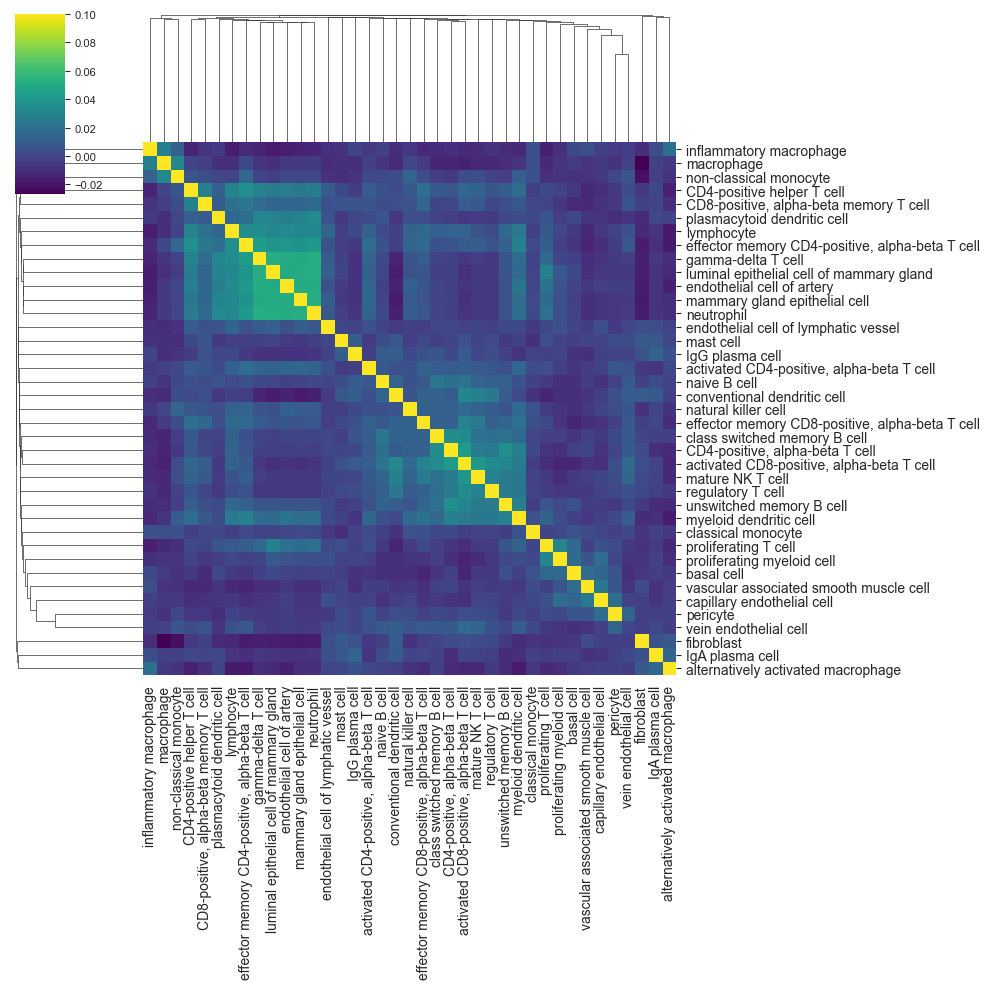

In [29]:
from tkinter import font
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


df_label = pd.read_csv(os.path.join(os.path.join("../moransR_results",  slide+"_MoranR_Cell2location.csv")), index_col=0)
df_figure = df_label[['A', 'B', 'R_val']]
correlation_df = df_figure.pivot(index="A", columns="B", values="R_val")
for var in correlation_df.index:
    correlation_df.at[var, var] = 1
    correlation_df = correlation_df.combine_first(correlation_df.T)
correlation_df = correlation_df.fillna(0) 
correlation_df['gamma-delta T cell'].gdT = 1.0
cell2location_cluster = sns.clustermap(correlation_df, figsize=(10, 10), cmap="viridis",vmax = 0.1)
cax = cell2location_cluster.ax_cbar
cax.tick_params(labelsize=8)
# save the linkage for the visulization of the Hist2Cell clustermap
row_linkage = cell2location_cluster.dendrogram_row.linkage
col_linkage = cell2location_cluster.dendrogram_col.linkage
heatmap_ax = cell2location_cluster.ax_heatmap
heatmap_ax.tick_params(axis='x', labelsize=10)  
heatmap_ax.tick_params(axis='y', labelsize=10)  
plt.show()
plt.close()

Then, we visualize the cluster map by the `Hist2Cell` prediction's results:

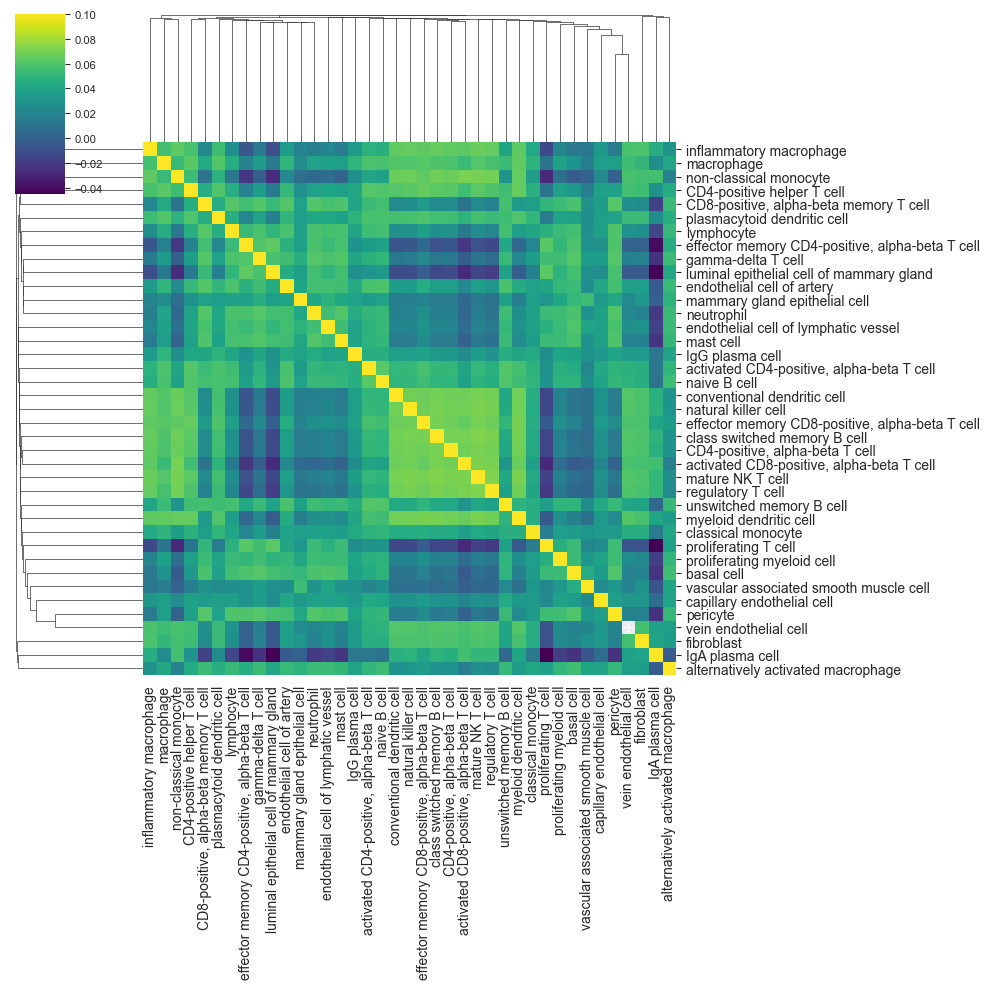

In [31]:
df_label = pd.read_csv(os.path.join("../moransR_results",  slide+"_MoranR_Hist2Cell.csv"), index_col=0)
df_figure = df_label[['A', 'B', 'R_val']]
correlation_df = df_figure.pivot(index="A", columns="B", values="R_val")
for var in correlation_df.index:
    correlation_df.at[var, var] = 1
    correlation_df = correlation_df.combine_first(correlation_df.T)
correlation_df['gamma-delta T cell'].gdT = 1.0
hist2cell_cluster = sns.clustermap(correlation_df, figsize=(10, 10), row_linkage=row_linkage, col_linkage=col_linkage, cmap="viridis",vmax = 0.1)
cax = hist2cell_cluster.ax_cbar
cax.tick_params(labelsize=8)
heatmap_ax = hist2cell_cluster.ax_heatmap
heatmap_ax.tick_params(axis='x', labelsize=10) 
heatmap_ax.tick_params(axis='y', labelsize=10) 
plt.show()
plt.close()